In [1]:
# Importamos las librerias necesarias
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

## Carga de datos
En la práctica 4 ya realicé la limpieza de datos, por lo que en esta práctica cargaremos el dataset limpio. En la [práctica 4](https://github.com/Luisruimor/practica4_IA) hice dos posibles tratamientos de los valores nulos de la columna "age":

1. Eliminar las filas con valores nulos
2. Imputar los valores mediante el método MICE

En esta práctica vamos a trabajar con el dataset en el que eliminé las columnas con valores nulos, ya que en el método MICE se utiliza la variable que queremos predecir como parte del método de imputación.

In [2]:
# Cargamos el dataset y mostramos las primeras filas
db=pd.read_csv("train_clean_0.csv")
db.head()

,Name,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,"Braund, Mr. Owen Harris",0,3,0,22.0,1,0,7.2500,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,1,1,38.0,1,0,71.2833,1
2,"Heikkinen, Miss. Laina",1,3,1,26.0,0,0,7.9250,0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1,1,35.0,1,0,53.1000,0
4,"Allen, Mr. William Henry",0,3,0,35.0,0,0,8.0500,0


## Definición de variable (recordatorio)
- Survived (si sobrevive el pasajero) = 0: Sobrevive, 1: No Sobrevive
- Pclass (la clase en la que se encontraba el pasajero ) = 1: 1a clase, 2: 2a clase, 3: 3a clase
- Sex (indica el sexo)= 0: masculino, 1: femenino
- Age (edad)
- SibSp (indica el número de hermanos, hermanastros, esposo/a que se encontraban a bordo)
- Parch (número total de padres e hijos a bordo)
- Fare (indica la tarifa/precio del ticket)
- Embarked (Indica desde donde zarpo el pasajero) = 0:Southampton ,1:Cherbourg, 2:Queenstown

In [3]:
db.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,0.406162,2.236695,0.365546,29.699118,0.512605,0.431373,34.694514,0.260504
std,0.491460,0.838250,0.481921,14.526497,0.929783,0.853289,52.918930,0.521012
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,20.125000,0.000000,0.000000,8.050000,0.000000
50%,0.000000,2.000000,0.000000,28.000000,0.000000,0.000000,15.741700,0.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,1.000000,33.375000,0.000000
max,1.000000,3.000000,1.000000,80.000000,5.000000,6.000000,512.329200,2.000000


## Preprocesamiento del Test Dataset

In [4]:
# Cargamos el dataset de test y mostramos las primeras filas
ExerciseTest=pd.read_csv("test_age_manual_imputed.csv")
db_test = ExerciseTest.copy()
db_test.head()

,Unnamed: 0,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,892,3,"Abelseth, Mr. Olaus Jorgensen",male,25.0,0,0,348122,7.6500,F G63,S
1,1,893,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
2,2,894,2,"Aldworth, Mr. Charles Augustus",male,30.0,0,0,248744,13.0000,NaN,S
3,3,895,2,"Andrew, Mr. Frank Thomas",male,25.0,0,0,C.A. 34050,10.5000,NaN,S
4,4,896,2,"Angle, Mr. William A",male,34.0,1,0,226875,26.0000,NaN,S


In [5]:
# Eliminamos las columnas PassengerId, Ticket, Unnamed y Cabin
db_test.drop(['PassengerId','Ticket','Unnamed: 0','Cabin'],axis=1,inplace=True)

# Mapeamos las columnas Embarked y Sex
db_test["Embarked"] = db_test["Embarked"].map({"S": 0, "C": 1, "Q": 2})
db_test["Sex"] = db_test["Sex"].map({"male": 0, "female": 1})

In [6]:
# Eliminamos la columna Name, que no nos aporta información relevante
db.drop('Name',axis=1,inplace=True)
db_test.drop('Name',axis=1,inplace=True)

In [7]:
# Calcular % de datos nulos por columna
for col in db_test.columns:
    print(col,":",db_test[col].isnull().sum()/db_test.shape[0]*100,"%")

Pclass : 0.0 %
Sex : 0.0 %
Age : 0.0 %
SibSp : 0.0 %
Parch : 0.0 %
Fare : 0.4784688995215311 %
Embarked : 0.0 %


### Procesamiento de los datos nulos
#### Procesamiento de los datos nulos de la columna "Fare"

In [8]:
# Mostrar los valores nulos de la columna Fare
db_test[db_test['Fare'].isnull()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
184,3,0,60.5,0,0,NaN,0


En el caso de la columna Fare solo hay un elemento nulo por lo que decidí investigar para ver si podía completar la información a mano. En este caso Storey, Mr. Thomas era parte de la tripulación por lo que el Fare es 0.
https://www.encyclopedia-titanica.org/titanic-victim/thomas-storey.html


In [9]:
# Rellenamos el valor nulo con 0
db_test['Fare'].fillna(0,inplace=True)

#### Procesamiento de los datos nulos de la columna "Age"
La columna "Age" tenía un 20% de valores nulos, en este caso impute los datos de forma manual, buscando en internet la edad de los pasajeros que no tenían edad registrada. Todos losa datos son de la web [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/titanic-victims/).

------------------------------------------------------------------------------------------------------------------------------

[Dataset orginal](test.csv)

[Dataset con datos imputados](test_age_manual_imputed.csv)

[Tabla con los datos imputados](imputacion_edad.md)

In [10]:
# Calcular % de datos nulos por columna
for col in db_test.columns:
    print(col,":",db_test[col].isnull().sum()/db_test.shape[0]*100,"%")

Pclass : 0.0 %
Sex : 0.0 %
Age : 0.0 %
SibSp : 0.0 %
Parch : 0.0 %
Fare : 0.0 %
Embarked : 0.0 %


## Normalización columna Fare

In [11]:
# Seleccionar la columna que deseas normalizar
column_to_normalize = db['Fare']
column_to_normalize_test = db_test['Fare']

# Crear una instancia del escalador MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos de la columna seleccionada
normalized_column = scaler.fit_transform(column_to_normalize.values.reshape(-1, 1))
normalized_column_test = scaler.fit_transform(column_to_normalize_test.values.reshape(-1, 1))

# Reemplazar la columna original con los datos normalizados
db['Fare'] = normalized_column
db_test['Fare'] = normalized_column_test

## Estandarización columna Age

In [12]:
# Seleccionar la columna que deseas estandarizar
column_to_standardize = db['Age']
column_to_standardize_test = db_test['Age']

# Crear una instancia del escalador StandardScaler
scaler = StandardScaler()

# Ajustar y transformar los datos de la columna seleccionada
standardized_column = scaler.fit_transform(column_to_standardize.values.reshape(-1, 1))
standardized_column_test = scaler.fit_transform(column_to_standardize_test.values.reshape(-1, 1))

# Reemplazar la columna original con los datos estandarizados
db['Age'] = standardized_column
db_test['Age'] = standardized_column_test

## KNN
El método KNN clasifica datos en función de su similitud con los datos de entrenamiento existentes. La "k" en KNN especifica el nuñemero de vecinos más cercanos que se toman en cuenta para hacer la predicción.
### Preparamos datos

In [13]:
X = db.drop('Survived',axis=1) # Todas las columnas menos Survived, que es la que queremos predecir
Y = db['Survived'] # La columna que queremos predecir

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Seleccionamos el valor de k
Analizo como se comporta el modelo con diferentes valores de k, y los represento en una gráfica para ver cual es el valor de k que mejor resultado nos da.

([<matplotlib.axis.XTick at 0x1d3137444c0>,
 [Text(0, 0, '0'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20')])

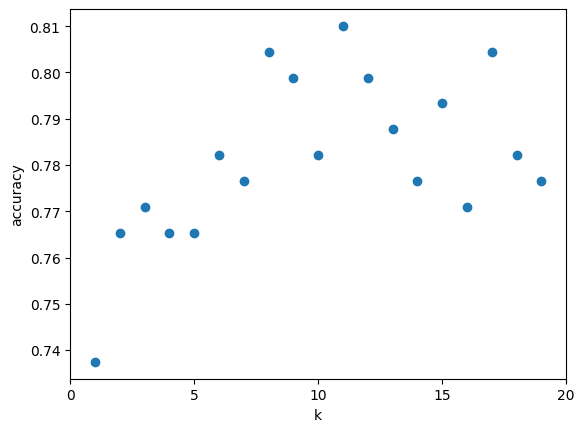

In [14]:
# Probamos con diferentes valores de k
k_range = range(1, 20)
scores = []
for k in k_range:
      knn = KNeighborsClassifier(n_neighbors = k)
      knn.fit(X_train, Y_train)
      scores.append(knn.score(X_test, Y_test))

# Los representamos en una gráfica
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

### Entrenamos el modelo con el valor de k que mejor resultado nos ha dado
Como se ve representado en la gráfica, el valor más alto de precisión del test set se obtiene con k=11, por lo que entreno el modelo con este valor de k.

In [15]:
n_neighbors = 11

# Creamos el modelo
knn = KNeighborsClassifier(n_neighbors)
# Lo entrenamos
knn.fit(X_train, Y_train)

# Imprimimos la precisión del modelo
print('Precisión del modelo en el set de entrenamiento: {:.2f}'
      .format(knn.score(X_train, Y_train)))
print('Precisión del modelo en el set de prueba: {:.2f}'
      .format(knn.score(X_test, Y_test)))

Precisión del modelo en el set de entrenamiento: 0.83
Precisión del modelo en el set de prueba: 0.81


In [16]:
predictSurvive = knn.predict(db_test)

output = pd.DataFrame({'PassengerId': ExerciseTest.PassengerId, 'Survived': predictSurvive })
output.to_csv('test_kaggle_KNN.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


c:\Users\Luis\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


## Naive Bayes

In [17]:
X = db.drop('Survived',axis=1) # Todas las columnas menos Survived, que es la que queremos predecir
Y = db['Survived'] # La columna que queremos predecir

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Crear una instancia del clasificador Naive Bayes (GaussianNB)
clf = GaussianNB()

# Ajustar el clasificador a los datos de entrenamiento
clf.fit(X_train, y_train)

GaussianNB()

In [18]:
# Realizar predicciones en los datos de prueba
predictSurvive = clf.predict(db_test)
output = pd.DataFrame({'PassengerId': ExerciseTest.PassengerId, 'Survived': predictSurvive })
output.to_csv('test_kaggle_NB.csv', index=False)

## Random Forest

In [19]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Crear una instancia del clasificador Random Forest
clf = RandomForestClassifier(n_estimators=100, max_depth=5)

# Ajustar el clasificador a los datos de entrenamiento
clf.fit(X_train, y_train)

# Realizar predicciones en los datos de prueba
y_pred = clf.predict(X_test)


In [20]:
# Exportar los resultados a un fichero csv
predictSurvive = clf.predict(db_test)
output = pd.DataFrame({'PassengerId': ExerciseTest.PassengerId, 'Survived': predictSurvive })
output.to_csv('test_kaggle_RF.csv', index=False)

## Decision Tree

In [21]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Crear una instancia del clasificador Random Forest
clf = DecisionTreeClassifier(max_depth=5)

# Ajustar el clasificador a los datos de entrenamiento
clf.fit(X_train, y_train)

# Realizar predicciones en los datos de prueba
y_pred = clf.predict(X_test)

In [22]:
# Exportar los resultados a un fichero csv
predictSurvive = clf.predict(db_test)
output = pd.DataFrame({'PassengerId': ExerciseTest.PassengerId, 'Survived': predictSurvive })
output.to_csv('test_kaggle_DT.csv', index=False)

## Regresión Logística

In [23]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Crear una instancia del modelo de Regresión Logística
model = LogisticRegression()

# Ajustar el modelo a los datos de entrenamiento
model.fit(X_train, y_train)

# Realizar predicciones en los datos de prueba
y_pred = model.predict(X_test)

In [24]:
#Exportar los resultados a un fichero csv
predictSurvive = model.predict(db_test)
output = pd.DataFrame({'PassengerId': ExerciseTest.PassengerId, 'Survived': predictSurvive })
output.to_csv('test_kaggle_LR.csv', index=False)